In [3]:
#Import python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import warnings

In [4]:
#load the data
data = pd.read_csv('../data/BTC-USD.csv')

In [5]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-11,54734.125000,57793.039063,54519.765625,57484.789063,57484.789063,42637331698
1,2021-10-12,57526.832031,57627.878906,54477.972656,56041.058594,56041.058594,41083758949
2,2021-10-13,56038.257813,57688.660156,54370.972656,57401.097656,57401.097656,41684252783
3,2021-10-14,57372.832031,58478.734375,56957.074219,57321.523438,57321.523438,36615791366
4,2021-10-15,57345.902344,62757.128906,56868.144531,61593.949219,61593.949219,51780081801


In [6]:
#list of columns
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
Date         366 non-null object
Open         366 non-null float64
High         366 non-null float64
Low          366 non-null float64
Close        366 non-null float64
Adj Close    366 non-null float64
Volume       366 non-null int64
dtypes: float64(5), int64(1), object(1)
memory usage: 20.1+ KB


#### Statistical description

In [8]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,366.000000,366.000000,366.000000,366.000000,366.000000,3.660000e+02
mean,36907.834129,37670.420754,35968.476216,36798.452922,36798.452922,3.094423e+10
std,13900.737769,14189.795472,13558.877330,13884.573587,13884.573587,9.658349e+09
min,18534.650391,19134.732422,17708.623047,18547.400391,18547.400391,1.373656e+10
25%,22584.017578,22994.634766,21623.773926,22508.751465,22508.751465,2.464335e+10
50%,38450.746094,39396.177735,37633.261719,38425.681640,38425.681640,3.008298e+10
75%,46268.938476,47086.675781,45351.858399,46126.001953,46126.001953,3.588560e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,8.419661e+10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0xffff76a6fd30>,
      dtype=object)

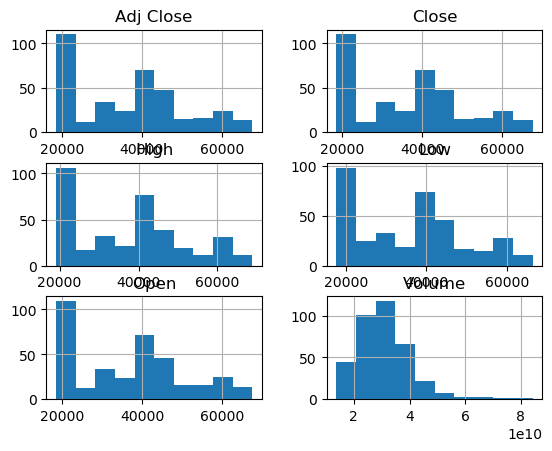

In [9]:
data.hist()

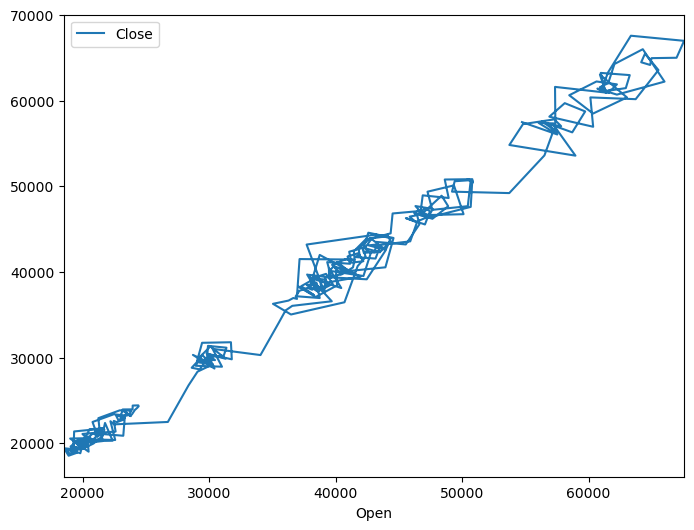

In [10]:
data.plot.line(x='Open', y='Close', figsize=(8,6))

#### Plot scatter for columns Open and Close

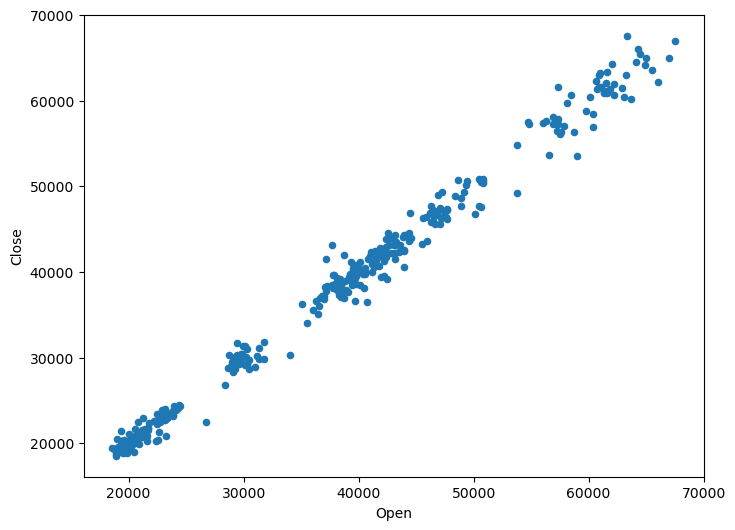

In [11]:
data.plot.scatter(x='Open', y='Close', figsize=(8,6))